# Loopless FBA

The goal of this procedure is identification of a thermodynamically consistent flux state without loops, as implied by the name.

Usually, the model has the following constraints.
$$ S \cdot v = 0 $$
$$ lb \le v \le ub $$

However, this will allow for thermodynamically infeasible loops (referred to as type 3 loops) to occur, where flux flows around a cycle without any net change of metabolites. For most cases, this is not a major issue, as solutions with these loops can usually be converted to equivalent solutions without them. However, if a flux state is desired which does not exhibit any of these loops, loopless FBA can be used. The formulation used here is modified from [Schellenberger et al.](http://dx.doi.org/10.1016/j.bpj.2010.12.3707)

We can make the model irreversible, so that all reactions will satisfy
$$ 0 \le lb \le v \le ub \le \max(ub) $$

We will add in boolean indicators as well, such that
$$ \max(ub) \cdot i \ge v $$
$$ i \in \{0, 1\} $$

We also want to ensure that an entry in the row space of S also exists with negative values wherever v is nonzero. In this expression, $1-i$ acts as a not to indicate inactivity of a reaction.

$$ S^\mathsf T x - (1 - i) (\max(ub) + 1) \le -1 $$

We will construct an LP integrating both constraints.

$$ \left(
\begin{matrix}
S & 0 & 0\\
-I & \max(ub)I & 0 \\
0 & (\max(ub) + 1)I & S^\mathsf T
\end{matrix}
\right)
\cdot
\left(
\begin{matrix}
v \\
i \\
x
\end{matrix}
\right)
\begin{matrix}
&=& 0 \\
&\ge& 0 \\
&\le& \max(ub)
\end{matrix}$$

Note that these extra constraints are not applied to boundary reactions which bring metabolites in and out of the system.

In [1]:
%matplotlib inline
import plot_helper

import cobra.test
from cobra import Reaction, Metabolite, Model
from cobra.flux_analysis.loopless import construct_loopless_model
from cobra.flux_analysis import optimize_minimal_flux
from cobra.solvers import get_solver_name

We will demonstrate with a toy model which has a simple loop cycling A -> B -> C -> A, with A allowed to enter the system and C allowed to leave. A graphical view of the system is drawn below:

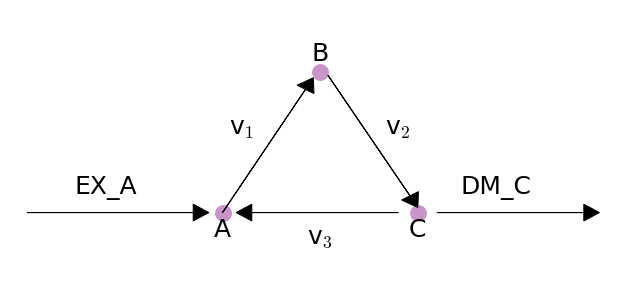

In [2]:
plot_helper.plot_loop()

In [3]:
test_model = Model()
test_model.add_metabolites([Metabolite(i) for i in "ABC"])
test_model.add_reactions([Reaction(i) for i in
                          ["EX_A", "DM_C", "v1", "v2", "v3"]])

test_model.reactions.EX_A.add_metabolites({"A": 1})
test_model.reactions.DM_C.add_metabolites({"C": -1})
test_model.reactions.DM_C.objective_coefficient = 1

test_model.reactions.v1.add_metabolites({"A": -1, "B": 1})
test_model.reactions.v2.add_metabolites({"B": -1, "C": 1})
test_model.reactions.v3.add_metabolites({"C": -1, "A": 1})

While this model contains a loop, a flux state exists which has no flux through reaction v3, and is identified by loopless FBA.

In [4]:
solution = construct_loopless_model(test_model).optimize()
print("loopless solution: status = " + solution.status)
print("loopless solution: v3 = %.1f" % solution.x_dict["v3"])

loopless solution: status = optimal
loopless solution: v3 = 0.0


If there there is no forced flux through a loopless reaction, parsimonious FBA will also have no flux through the loop.

In [5]:
solution = optimize_minimal_flux(test_model)
print("parsimonious solution: status = " + solution.status)
print("parsimonious solution: v3 = %.1f" % solution.x_dict["v3"])

parsimonious solution: status = optimal
parsimonious solution: v3 = 0.0


However, if flux is forced through v3, then there is no longer a feasible loopless solution, but the parsimonious solution will still exist.

In [6]:
test_model.reactions.v3.lower_bound = 1
solution = construct_loopless_model(test_model).optimize()
print("loopless solution: status = " + solution.status)

loopless solution: status = infeasible


In [7]:
solution = optimize_minimal_flux(test_model)
print("parsimonious solution: status = " + solution.status)
print("parsimonious solution: v3 = %.1f" % solution.x_dict["v3"])

parsimonious solution: status = optimal
parsimonious solution: v3 = 1.0


Loopless FBA is also possible on genome scale models, but it requires a capable MILP solver. If one is installed, cobrapy can detect it automatically using the get_solver_name function

In [8]:
mip_solver = get_solver_name(mip=True)
print(mip_solver)

cplex


In [9]:
salmonella = cobra.test.create_test_model("salmonella")
construct_loopless_model(salmonella).optimize(solver=mip_solver)

<Solution 0.38 at 0x7f9285d7ffd0>

In [10]:
ecoli = cobra.test.create_test_model("ecoli")
construct_loopless_model(ecoli).optimize(solver=mip_solver)

<Solution 0.98 at 0x7f9285c89470>